<a href="https://www.kaggle.com/code/salilapte/image-caption-cnn-generator?scriptVersionId=229781976" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


Epoch 1/17, Loss: 4.0054
Epoch 2/17, Loss: 3.3841
Epoch 3/17, Loss: 3.1956
Epoch 4/17, Loss: 3.0516
Epoch 5/17, Loss: 3.0088
Epoch 6/17, Loss: 2.9323
Epoch 7/17, Loss: 2.8820
Epoch 8/17, Loss: 2.8457
Epoch 9/17, Loss: 2.8462
Epoch 10/17, Loss: 2.7992
Epoch 11/17, Loss: 2.7789
Epoch 12/17, Loss: 2.7707
Epoch 13/17, Loss: 2.7466
Epoch 14/17, Loss: 2.7189
Epoch 15/17, Loss: 2.7112
Epoch 16/17, Loss: 2.6856
Epoch 17/17, Loss: 2.6824


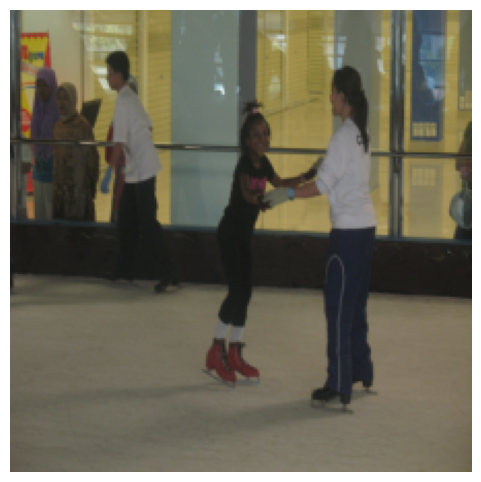

Generated Caption: an elderly young boy with camouflage they <UNK> skating inside a rain up sign .

Actual Caption: An older girl helps a younger girl ice skate .

Similarity Score: 0.0464



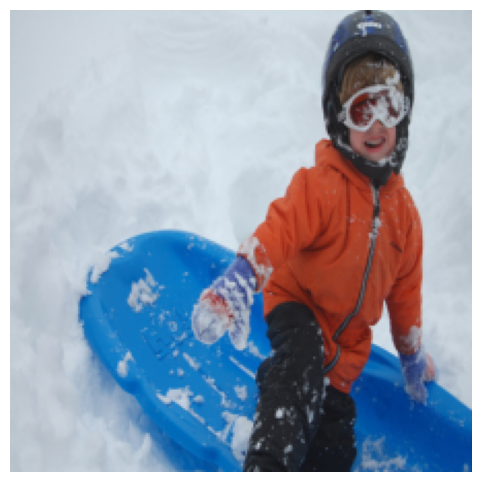

Generated Caption: the <UNK> a snow .

Actual Caption: A child on a plastic sled .

Similarity Score: 0.0000



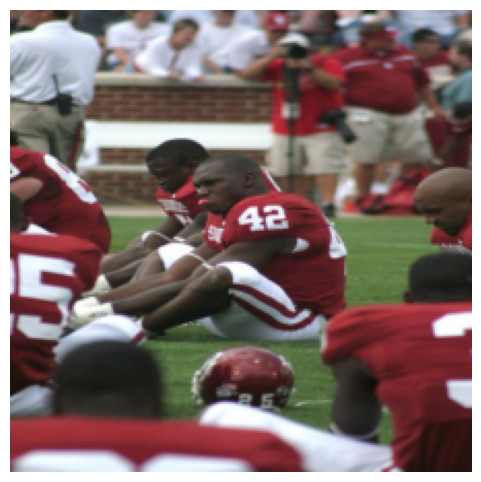

Generated Caption: football players in red jerseys .

Actual Caption: african Americans play football .

Similarity Score: 0.1274



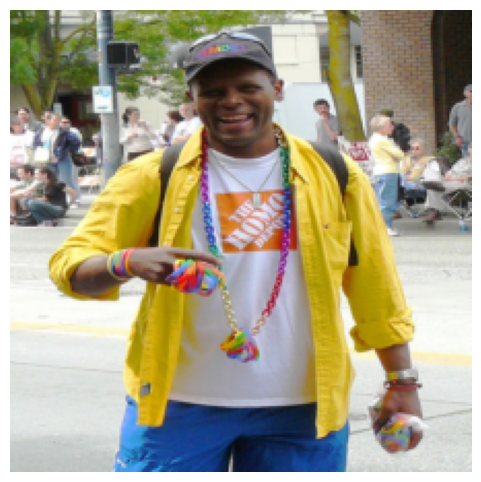

Generated Caption: children trying to jump to something to get a bat .

Actual Caption: A man in a yellow jacket with many colorful wristbands is smiling .

Similarity Score: 0.0000



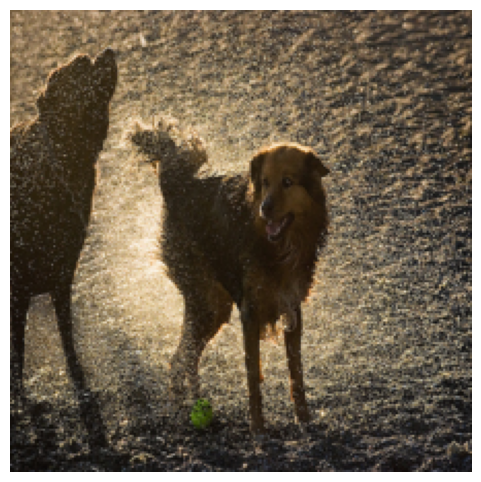

Generated Caption: a wet large colored dog shaking he a large two shaking towards a lake .

Actual Caption: Two dogs shake off water in an area with very little vegetation .

Similarity Score: 0.0392



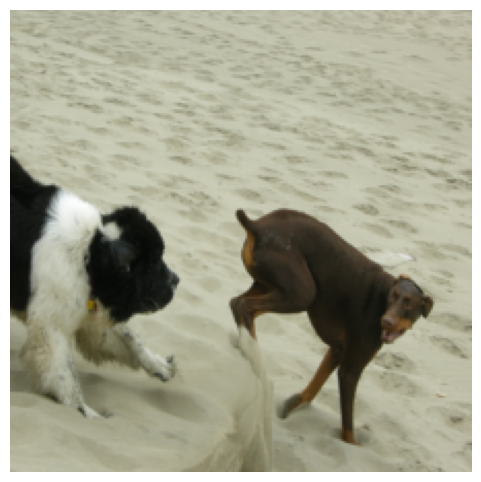

Generated Caption: a brown doberman to hit .

Actual Caption: One dog is chasing another one on the beach .

Similarity Score: 0.0000



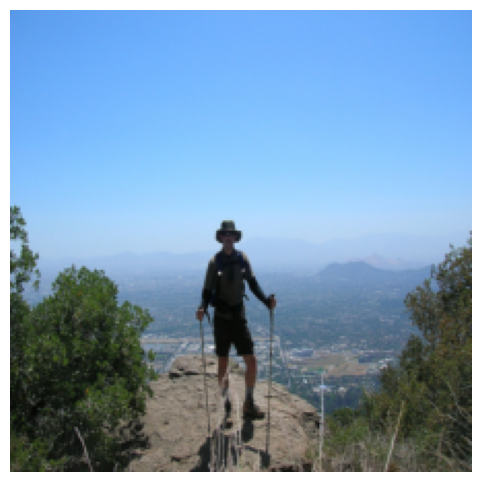

Generated Caption: a single hiker on top of a mountain ground gathered overlooking a mountain poles is

Actual Caption: A hiker with two sticks is a standing on a path that is high up on a hill .

Similarity Score: 0.1943



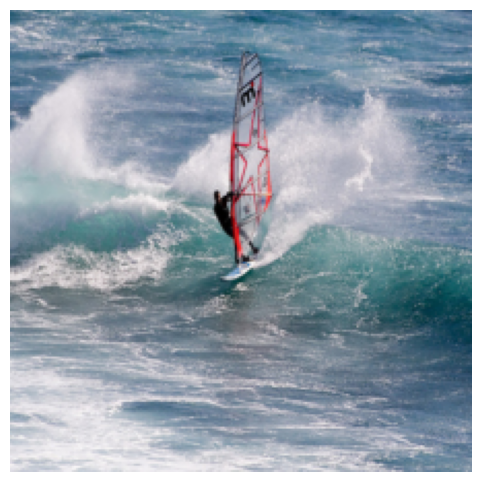

Generated Caption: the red of a <UNK> a wave .

Actual Caption: A person parasails on the crest of a wave .

Similarity Score: 0.3446



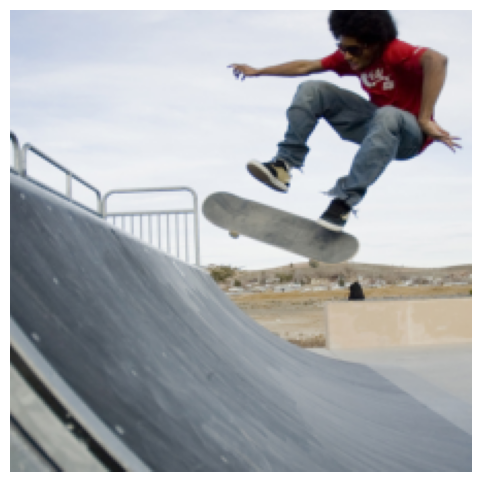

Generated Caption: a boy uses a trick off of a red overlooking a jump .

Actual Caption: The skateboarder is performing a trick off a ramp .

Similarity Score: 0.1559



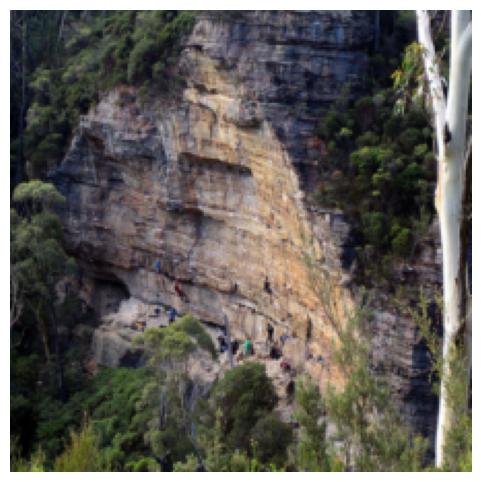

Generated Caption: a group of people climb underneath a mountain .

Actual Caption: The flat side of a large , rocky mountain .

Similarity Score: 0.1844



In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
nltk.download('punkt')

# ----------------------------
# 1. Device Configuration
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# 2. CNN Feature Extractor (ResNet50)
# ----------------------------
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # remove final FC layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, 512)

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)  # [B, 2048, 1, 1]
            features = features.view(features.size(0), -1)
        return self.fc(features)

# ----------------------------
# 3. Transformer Decoder for Captioning
# ----------------------------
class CaptionGenerator(nn.Module):
    def __init__(self, feature_size=512, hidden_size=512, vocab_size=2002, num_layers=2, num_heads=8):
        super(CaptionGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 50, hidden_size))
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads), num_layers
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        captions = torch.clamp(captions, min=0, max=2001)
        captions = self.embedding(captions) + self.pos_encoder[:, :captions.size(1), :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(captions.device)
        output = self.transformer_decoder(captions.permute(1, 0, 2), features.unsqueeze(0), tgt_mask).permute(1, 0, 2)
        return self.fc(output)

# ----------------------------
# 4. Flickr8k Dataset
# ----------------------------
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.captions_df = pd.read_csv(captions_file)
        self.image_files = list(self.captions_df['image'].unique())[:4000]
        self.captions = {img: self.captions_df[self.captions_df['image'] == img]['caption'].tolist() for img in self.image_files}

        all_tokens = [word_tokenize(c.lower()) for captions in self.captions.values() for c in captions]
        word_counts = Counter([word for caption in all_tokens for word in caption])
        self.vocab = {word: i + 4 for i, (word, _) in enumerate(word_counts.most_common(2000))}
        self.vocab["<UNK>"] = 1
        self.vocab["<PAD>"] = 0
        self.vocab["<SOS>"] = 2
        self.vocab["<EOS>"] = 3
        self.idx_to_word = {idx: word for word, idx in self.vocab.items()}

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        actual_captions = self.captions[self.image_files[idx]]
        if self.transform:
            image = self.transform(image)
        return image, actual_captions

    def __len__(self):
        return len(self.image_files)

# ----------------------------
# 5. Collate Function
# ----------------------------
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, captions

# ----------------------------
# 6. Load Dataset and Initialize
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_dir = "/kaggle/input/flickr8k/Images"
captions_file = "/kaggle/input/flickr8k/captions.txt"
dataset = torch.utils.data.Subset(Flickr8kDataset(image_dir, captions_file, transform=transform), range(2000))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# ----------------------------
# 7. Training Setup
# ----------------------------
feature_extractor = CNNFeatureExtractor().to(device)
vocab_size = len(dataset.dataset.vocab)
caption_model = CaptionGenerator(vocab_size=vocab_size).to(device)
optimizer = optim.Adam(caption_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# ----------------------------
# 8. Training Loop
# ----------------------------
epochs = 17
caption_model.train()
for epoch in range(epochs):
    total_loss = 0
    for images, actual_captions in dataloader:
        images = images.to(device)
        features = feature_extractor(images)

        tokenized_captions = []
        for caps in actual_captions:
            selected_caption = random.choice(caps)
            tokens = [dataset.dataset.vocab.get(word, 1) for word in word_tokenize(selected_caption.lower())[:20]]
            tokens = [2] + tokens + [3]  # <SOS> and <EOS>
            tokenized_captions.append(torch.tensor(tokens, device=device))

        padded = nn.utils.rnn.pad_sequence(tokenized_captions, batch_first=True, padding_value=0)
        inputs = padded[:, :-1]
        targets = padded[:, 1:]

        optimizer.zero_grad()
        output = caption_model(features, inputs)
        loss = criterion(output.view(-1, output.shape[-1]), targets.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# ----------------------------
# 9. Inference
# ----------------------------
caption_model.eval()
feature_extractor.eval()

vectorizer = TfidfVectorizer()
selected_indices = random.sample(range(len(dataset)), 10)
selected_images = [dataset[i] for i in selected_indices]

for image, actual_captions in selected_images:
    image_tensor = image.unsqueeze(0).to(device)
    features = feature_extractor(image_tensor)

    caption = [2]  # <SOS>
    for _ in range(15):
        input_seq = torch.tensor(caption, device=device).unsqueeze(0)
        output = caption_model(features, input_seq)
        probs = torch.softmax(output[:, -1, :], dim=-1).squeeze(0)
        next_word = torch.multinomial(probs, 1).item()
        if next_word == 3:  # <EOS>
            break
        caption.append(next_word)

    generated_caption = " ".join([dataset.dataset.idx_to_word.get(idx, "<UNK>") for idx in caption[1:]])
    actual_caption_text = random.choice(actual_captions)

    tfidf_matrix = vectorizer.fit_transform([generated_caption, actual_caption_text])
    similarity_score = (tfidf_matrix * tfidf_matrix.T).toarray()[0, 1]

    plt.figure(figsize=(6, 6))
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()
    print(f"Generated Caption: {generated_caption}\n")
    print(f"Actual Caption: {actual_caption_text}\n")
    print(f"Similarity Score: {similarity_score:.4f}\n")